#   Imports

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
from pprint import pprint
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

#   Importing the dataset

##  Dataset Information

- 0 - polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
- id of the tweet
- date of the tweet
- query. If no query, the NO_QUERY
- user of the tweet
- content of the tweet (no emoticons)

In [3]:
if os.path.exists('data.zip'):
    with zipfile.ZipFile('data.zip', 'r') as zip_ref:
        zip_ref.extractall(os.getcwd())
cols = ["sentiment", "id", "date", "query_string", "user", "text"]
df = pd.read_csv("data/training.1600000.processed.noemoticon.csv", header=None, names=cols, encoding='utf-8-sig', encoding_errors='ignore')
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


#   Explore

##  Data Cleaning
- look at value counts for each column
- drop columns that are not needed

##  Update
-   decided to remove id since it does not play a role in determining sentiment
-   decided to remove date since it has no effect on sentiment
-   decided to remove query since all values are the same
-   decided to remove user since it has no effect on sentiment

##  Observations
-   all negative class is from 0 - 799999 th index
-   positive class entries start from 800000 th index
-   the box plot seems strange, twitter's character limit is 140, however some of the tweets cross that limit

In [4]:
df.sentiment.value_counts()

sentiment
0    800000
4    800000
Name: count, dtype: int64

In [5]:
df.query_string.value_counts()

query_string
NO_QUERY    1600000
Name: count, dtype: int64

In [6]:
df.drop(["id", "date", "query_string", "user"], axis=1, inplace=True)
df[df.sentiment == 0].head(10)

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
5,0,@Kwesidei not the whole crew
6,0,Need a hug
7,0,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,@Tatiana_K nope they didn't have it
9,0,@twittera que me muera ?


In [7]:
df[df.sentiment == 4].head(10)

,sentiment,text
800000,4,I LOVE @Health4UandPets u guys r the best!!
800001,4,im meeting up with one of my besties tonight! ...
800002,4,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,4,Being sick can be really cheap when it hurts t...
800004,4,@LovesBrooklyn2 he has that effect on everyone
800005,4,@ProductOfFear You can tell him that I just bu...
800006,4,@r_keith_hill Thans for your response. Ihad al...
800007,4,"@KeepinUpWKris I am so jealous, hope you had a..."
800008,4,"@tommcfly ah, congrats mr fletcher for finally..."
800009,4,@e4VoIP I RESPONDED Stupid cat is helping me ...


In [8]:
df["pre_clean_len"] = [len(t) for t in df.text]

- Create a data dictionary
- Box plot to see the overall distribution of length of strings in each entry

In [9]:
data_dict = {
    'sentiment': {
        'type': df.sentiment.dtype,
        'descr': 'sentiment class - 0: negative, 1: positive'
    },
    'text': {
        'type': df.text.dtype,
        'descr': 'tweet text'
    },
    'pre_clean_len': {
        'type': df.pre_clean_len.dtype,
        'descr': 'Length of the tweet before cleaning'
    },
    'dataset_shape': df.shape
}

pprint(data_dict)

{'dataset_shape': (1600000, 3),
 'pre_clean_len': {'descr': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'sentiment': {'descr': 'sentiment class - 0: negative, 1: positive',
               'type': dtype('int64')},
 'text': {'descr': 'tweet text', 'type': dtype('O')}}


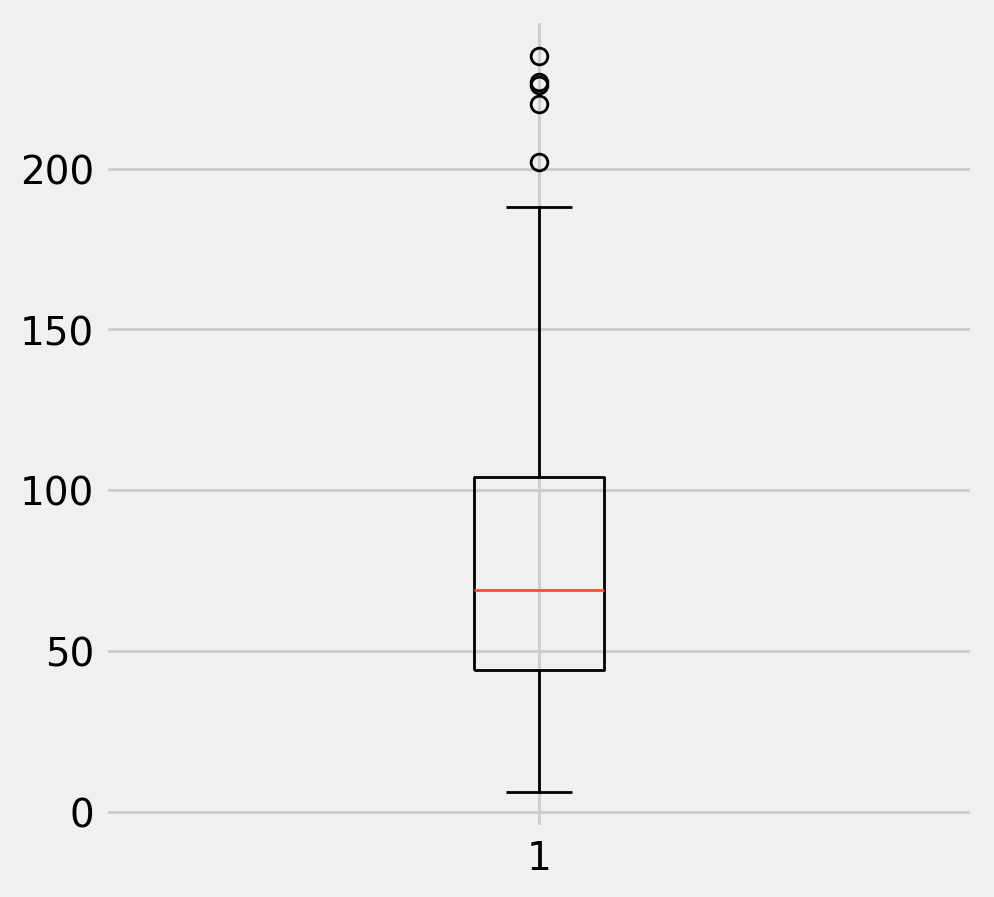

In [10]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

In [11]:
df[df.pre_clean_len > 140].head(10)

,sentiment,text,pre_clean_len
213,0,Awwh babs... you look so sad underneith that s...,142
279,0,Whinging. My client&amp;boss don't understand ...,145
343,0,@TheLeagueSF Not Fun &amp; Furious? The new ma...,145
400,0,#3 woke up and was having an accident - &quot;...,144
464,0,"My bathtub drain is fired: it haz 1 job 2 do, ...",146
492,0,"pears &amp; Brie, bottle of Cabernet, and &quo...",150
747,0,Have an invite for &quot;Healthy Dining&quot; ...,141
957,0,Damnit I was really digging this season of Rea...,141
1064,0,Why do I keep looking...I know that what I rea...,141
1071,0,Used the term &quot;Fail Whale&quot; to a clie...,148


#   Data Preparation
- looks like HTML encoding has not been converted to text, hence decoding HTML to general text; using BeautifulSoup
- deal with @mentions as this info does not add value to build the sentiment analysis
- remove URL links
- UTF-8 BOM (byte order mark)
- keep text intact and just remove the '#'

In [12]:
df.text[279]

"Whinging. My client&amp;boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly. "

In [13]:
ex1 = BeautifulSoup(df.text[279], 'lxml')   #   you may have to install lxml
print(ex1.get_text())

Whinging. My client&boss don't understand English well. Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. 


In [14]:
df.text[343]

'@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [15]:
import re
re.sub(r'@[A-Za-z0-9]+', '', df.text[343])

' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? It was getting 2 rambunctious;the city overreacted &amp; clamped down '

In [16]:
df.text[0]

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [17]:
re.sub('https?://[A-Za-z0-9./]+', '', df.text[0])

"@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [18]:
df.text[226]

'Tuesday�ll start with reflection �n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [19]:
testing = (df.text[226])
testing.replace(u'\ufffd', '?')

'Tuesday?ll start with reflection ?n then a lecture in Stress reducing techniques. That sure might become very useful for us accompaniers '

In [20]:
df.text[175]

"@machineplay I'm so sorry you're having to go through this. Again.  #therapyfail"

In [21]:
re.sub('[^a-zA-Z]', ' ', df.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

#   Defining Data Cleaning Function
-   souping
-   BOM removing
-   url address('http:'pattern), twitter ID removing
-   url address('www.'pattern) removing
-   lower case
-   negation handling (isn't -> is not, wasn't -> was not, etc.)
-   removing numbers and special characters
-   tokenizing and joining

In [22]:
tok = WordPunctTokenizer()

user_pat = r'@[A-Za-z0-9]+'
https_pat = r'https?://[^ ]+'
wwe_pat = r'www.[^ ]+'

combined_pat = r'|'.join((r'|'.join((user_pat, https_pat)), wwe_pat))

negations = {"isn't": "is not",
             "aren't": "are not",
             "wasn't": "was not",
             "weren't": "were not",
             "haven't": "have not",
             "hasn't": "has not",
             "hadn't": "had not",
             "won't": "will not",
             "wouldn't": "would not",
             "don't": "do not",
             "doesn't": "does not",
             "didn't": "did not",
             "can't": "can not",
             "couldn't": "could not",
             "shouldn't": "should not",
             "mightn't": "might not",
             "mustn't": "must not"}

neg_pat = re.compile(r'\b(' + '|'.join(negations.keys()) + r')\b')

def clean_tweet(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()

    try:
        bom_removed = souped.replace(u'\ufffd', '?')
    except:
        bom_removed = souped

    stripped = re.sub(combined_pat, '', bom_removed).lower()
    neg_handled = neg_pat.sub(lambda x: negations[x.group()], stripped)
    letters = re.sub("[^a-zA-Z]", " ", neg_handled)

    #   removing unnecessary white spaces
    words = [x for x in tok.tokenize(letters) if len(x) > 1]
    
    return (" ".join(words)).strip()

testing = df.text[:100]

test_result = []
for t in testing:
    test_result.append(clean_tweet(t))
test_result

/tmp/ipykernel_1260761/1360330646.py:30: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')


['awww that bummer you shoulda got david carr of third day to do it',
 'is upset that he can not update his facebook by texting it and might cry as result school today also blah',
 'dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it not behaving at all mad why am here because can not see you all over there',
 'not the whole crew',
 'need hug',
 'hey long time no see yes rains bit only bit lol fine thanks how you',
 'nope they did not have it',
 'que me muera',
 'spring break in plain city it snowing',
 'just re pierced my ears',
 'could not bear to watch it and thought the ua loss was embarrassing',
 'it it counts idk why did either you never talk to me anymore',
 'would ve been the first but did not have gun not really though zac snyder just doucheclown',
 'wish got to watch it with you miss you and how was the premiere',
 'hollis death scene will hurt me severely to watch on film wry is directors cut no

In [23]:
#   divide into four batches and clean
batch = [0, 400000, 800000, 1200000, 1600000]
print("Cleaning and parsing tweets \n")
clean_tweets = []
j = 0
while (j < len(batch) - 1):
    for i in range(batch[j], batch[j+1]):
        if ((i+1) % 50000 == 0):
            print(f"Tweets {i+1} of {batch[j+1]} processed")
        clean_tweets.append(clean_tweet(df['text'][i]))
    j += 1

Cleaning and parsing tweets 



/tmp/ipykernel_1260761/1360330646.py:30: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'lxml')


Tweets 50000 of 400000 processed
Tweets 100000 of 400000 processed
Tweets 150000 of 400000 processed
Tweets 200000 of 400000 processed
Tweets 250000 of 400000 processed
Tweets 300000 of 400000 processed
Tweets 350000 of 400000 processed
Tweets 400000 of 400000 processed
Tweets 450000 of 800000 processed
Tweets 500000 of 800000 processed
Tweets 550000 of 800000 processed
Tweets 600000 of 800000 processed
Tweets 650000 of 800000 processed
Tweets 700000 of 800000 processed
Tweets 750000 of 800000 processed
Tweets 800000 of 800000 processed
Tweets 850000 of 1200000 processed
Tweets 900000 of 1200000 processed
Tweets 950000 of 1200000 processed
Tweets 1000000 of 1200000 processed
Tweets 1050000 of 1200000 processed
Tweets 1100000 of 1200000 processed
Tweets 1150000 of 1200000 processed
Tweets 1200000 of 1200000 processed
Tweets 1250000 of 1600000 processed
Tweets 1300000 of 1600000 processed
Tweets 1350000 of 1600000 processed
Tweets 1400000 of 1600000 processed
Tweets 1450000 of 1600000 pr

In [24]:
df_clean = pd.DataFrame(clean_tweets, columns=['text'])
df_clean['target'] = df.sentiment
df_clean.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [25]:
datapath = 'data'
filename = 'clean_tweets.csv'
filepath = os.path.join(datapath, filename)
df_clean.to_csv(filepath, encoding='utf-8')
data = pd.read_csv(filepath, index_col=0)
data.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596516 non-null  object
 1   target  1600000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 36.6+ MB


In [27]:
data[data.isnull().any(axis=1)].head()

,text,target
208,NaN,0
249,NaN,0
398,NaN,0
430,NaN,0
1011,NaN,0


In [28]:
np.sum(data.isnull().any(axis=1))

3484

In [29]:
data.isnull().any(axis=0)

text       True
target    False
dtype: bool

In [30]:
temp = pd.read_csv('data/training.1600000.processed.noemoticon.csv', encoding='utf-8', encoding_errors='ignore',header=None)
temp.iloc[data[data.isnull().any(axis=1)].index, :].head()

,0,1,2,3,4,5
208,0,1467863072,Mon Apr 06 22:33:25 PDT 2009,NO_QUERY,Artiel87,@mandayyy
249,0,1467874569,Mon Apr 06 22:36:27 PDT 2009,NO_QUERY,Artiel87,@mandayyy
398,0,1467912842,Mon Apr 06 22:46:53 PDT 2009,NO_QUERY,KimberlyKane,@danadearmond
430,0,1467919452,Mon Apr 06 22:48:48 PDT 2009,NO_QUERY,jtmal0723,@anistorm
1011,0,1468061127,Mon Apr 06 23:30:23 PDT 2009,NO_QUERY,gabysslave,@citizensheep


In [31]:
data.dropna(inplace=True)
data.reset_index(drop=True, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596516 entries, 0 to 1596515
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1596516 non-null  object
 1   target  1596516 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


#   Word Cloud

In [32]:
negative_tweets = data[data.target == 0]
negative = [t for t in negative_tweets.text]
negative = pd.Series(negative).str.cat(sep=' ')

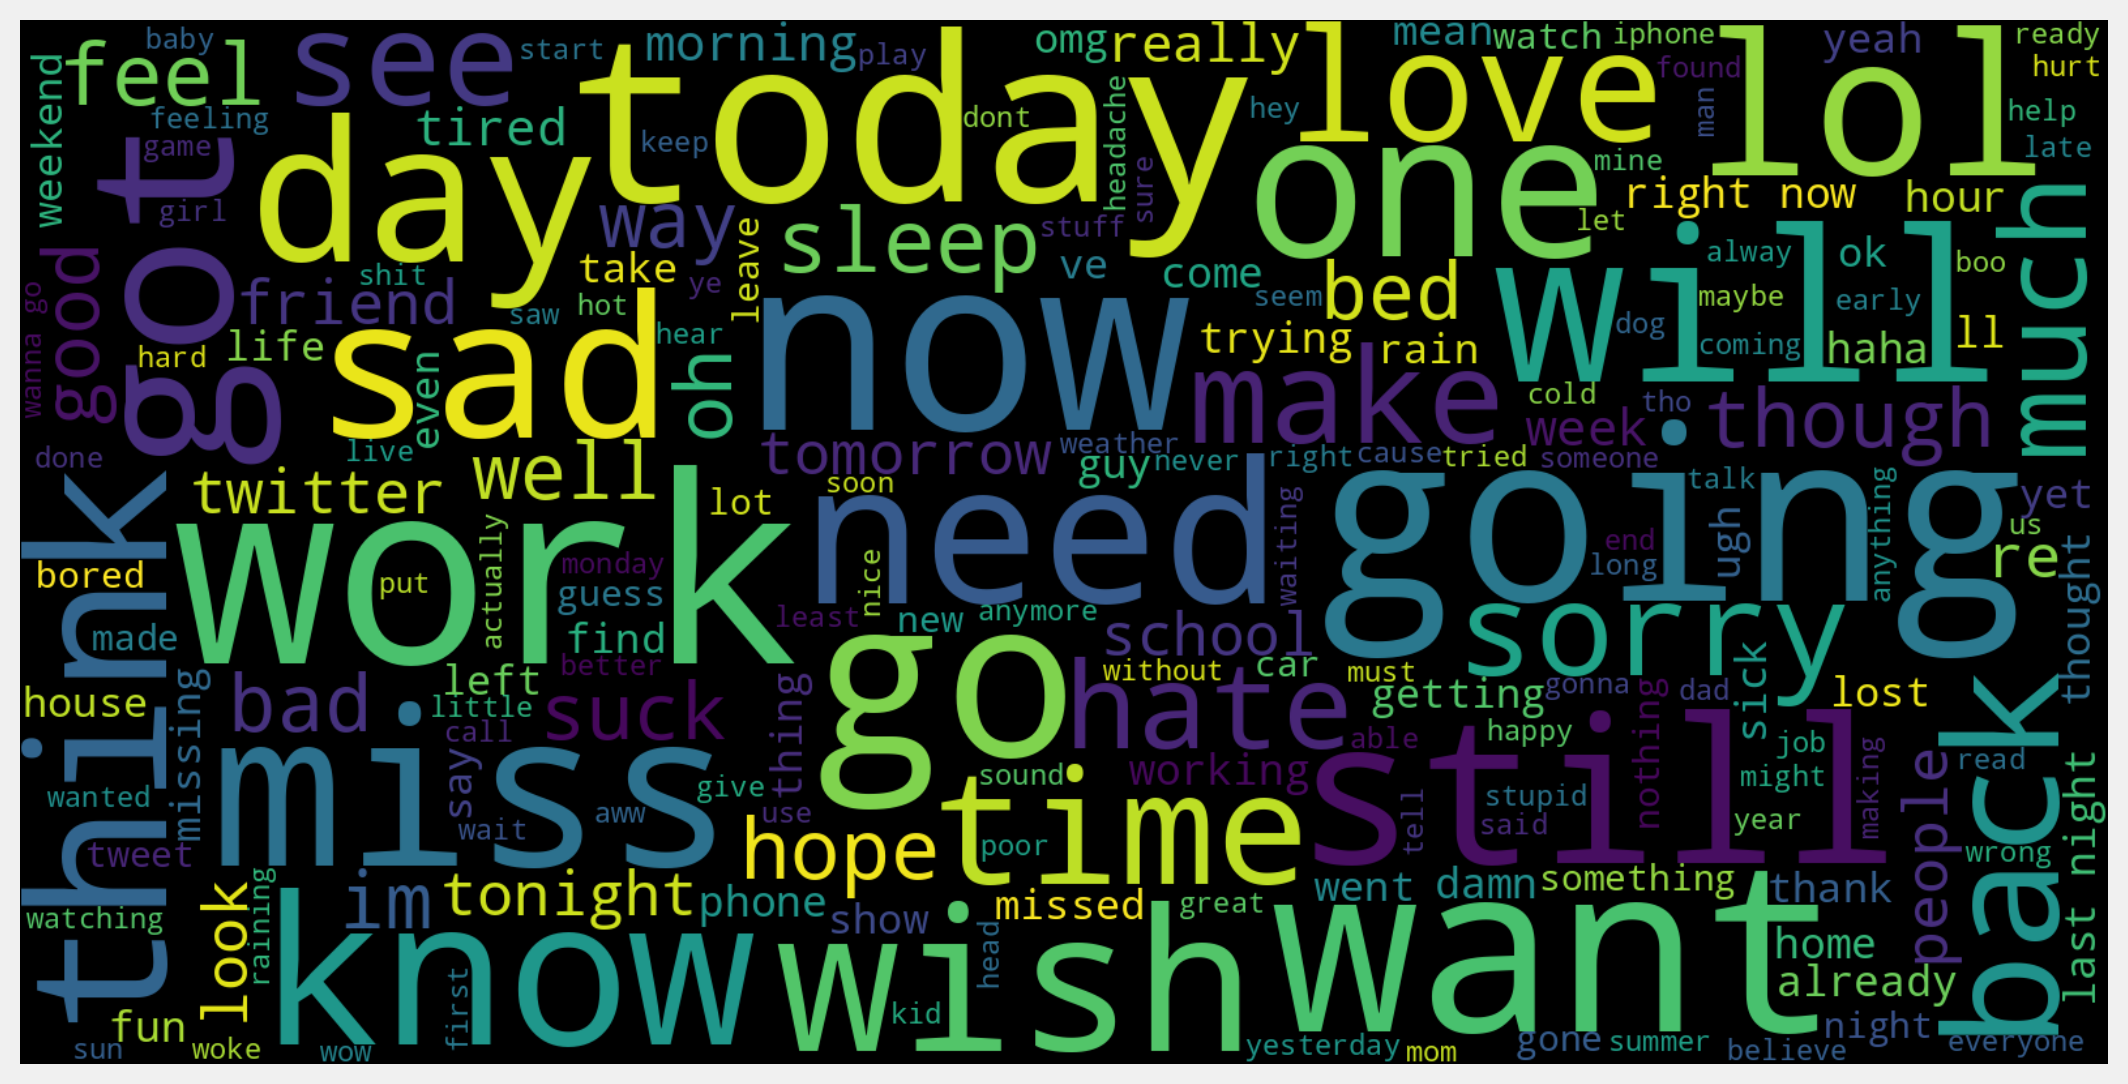

In [33]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(negative)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [34]:
for t in negative_tweets.text[:200]:
    if 'love' in t:
        print(t)

ahh ive always wanted to see rent love the soundtrack
meh almost lover is the exception this track gets me depressed every time
awe love you too am here miss you
damn the grind is inspirational and saddening at the same time do not want you to stop cuz like what do much love
missing you babe but as long as your alive happy ya tired my love imma try to sleep hopefully you had headstart
love the french tell people here in the south qtr french and they snarl at me french are beautiful people


- even though the tweets contain the word 'love', in the above cases it is used in a negative context
- as in mixed emotions like 'love' and 'miss', or sometimes used in a sarcastic way

In [35]:
positive_tweets = data[data.target == 4]
positive = [t for t in positive_tweets.text]
positive = pd.Series(positive).str.cat(sep=' ')

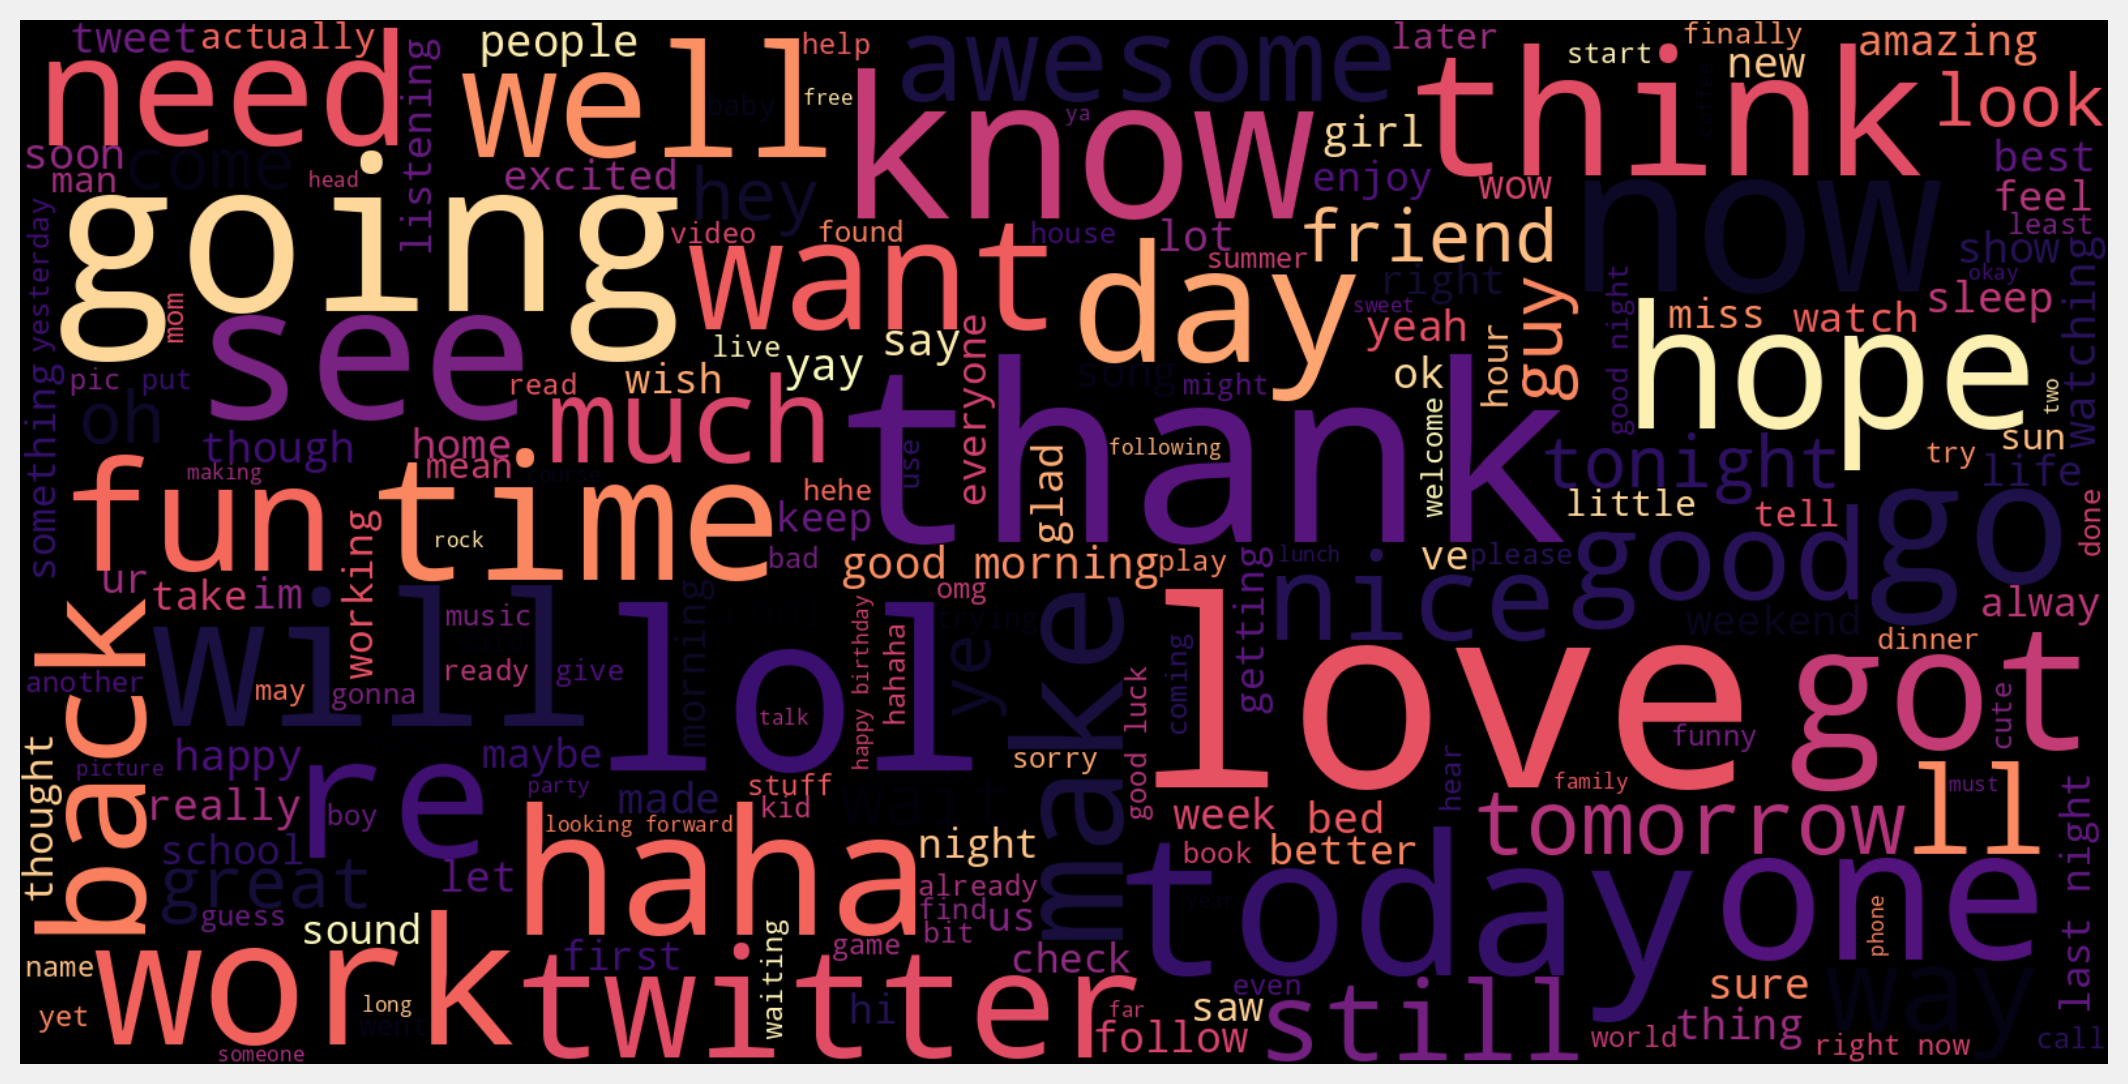

In [36]:
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, colormap='magma').generate(positive)
plt.figure(figsize=(12, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [37]:
data[data.target == 1]

,text,target


In [38]:
data.target.value_counts()

target
0    798397
4    798119
Name: count, dtype: int64

## Preparing for more data visualization

In [39]:
cvec = CountVectorizer()
cvec.fit(data.text)

CountVectorizer()

In [40]:
len(cvec.get_feature_names_out())

269782

In [43]:
negative_document_matrix = cvec.transform(data[data.target == 0].text)
positive_document_matrix = cvec.transform(data[data.target == 4].text)
negative_tf = np.sum(negative_document_matrix, axis=0)
positive_tf = np.sum(positive_document_matrix, axis=0)
negatives = np.squeeze(np.asarray(negative_tf))
positives = np.squeeze(np.asarray(positive_tf))

term_frequency_df = pd.DataFrame([negatives, positives], columns=cvec.get_feature_names_out()).transpose()

In [45]:
term_frequency_df.columns = ['negative', 'positive']
term_frequency_df['total'] = term_frequency_df['negative'] + term_frequency_df['positive']
term_frequency_df.sort_values(by='total', ascending=False).iloc[:10]

,negative,positive,total
to,313183,252596,565779
the,257952,266152,524104
my,190803,125980,316783
it,157491,147836,305327
and,153984,149687,303671
you,103865,198272,302137
not,194738,86877,281615
is,133529,111318,244847
in,115628,101294,216922
for,99039,117389,216428
